## Problems

### Conversion
1.	Is it possible to predict customer conversion (from viewing to purchasing)?
2.	Can we identify “new customers”? If yes then what is the best strategy to work with them?
3.	What are the top features that define customer conversion?
4.	Can we explain and visualize the predictive model for customer conversion on a journey and at a session level?
5.	Is there a pattern and trend across product types regarding the conversion event?

### Personalization
1.	Can we personalize the experience from customer-product interactions?
2.	Does the product catalogue information help in improving customer experience?
3.	Can personalized shopping experience be predictively modeled?
4.	Can we apply transfer learning from other E-commerce data sets to our local data set?

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
df = pd.read_json('raw_data.json',lines=True)
# df = pd.read_json('raw_data.json', lines=True, chunksize = 10000)

In [3]:
df.columns

Index(['customerId', 'customerArea', 'customerVisitorId', 'customerLoginId',
       'customerSessionId', 'sessionStartTime', 'sessionEndTime',
       'customerSessionNumber', 'totals', 'attributedTotals', 'trafficSource',
       'hits'],
      dtype='object')

In [110]:
len(pd.unique(df['customerSessionId']))

48039

## Data Exploration

In [8]:
transformed_df = df[['customerId','customerVisitorId','customerSessionId',
                     'sessionStartTime','sessionEndTime', 'customerSessionNumber']]
transformed_df.loc[:,'deviceCategory'] = df['trafficSource'].transform(lambda x: x.get('deviceCategory',''))
transformed_df.loc[:,'browser'] = df['trafficSource'].transform(lambda x: x.get('browser',''))
transformed_df.loc[:,'os'] = df['trafficSource'].transform(lambda x: x.get('os',''))
transformed_df.loc[:,'userAgent'] = df['trafficSource'].transform(lambda x: x.get('userAgent',''))
transformed_df.loc[:,'language']=df['trafficSource'].transform(lambda x: x.get('language'))
transformed_df.loc[:,'source']=df['trafficSource'].transform(lambda x: x.get('source'))
transformed_df.loc[:,'has_campaign']=df['trafficSource'].transform(lambda x: 1 if x.get('campaign') is not None else 0)
transformed_df.loc[:,'sessionStartTime'] = df['sessionStartTime'].transform(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f %Z'))
transformed_df.loc[:,'sessionEndTime'] = df['sessionEndTime'].transform(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f %Z'))
transformed_df.loc[:,'sessionDuration'] = df[['sessionStartTime','sessionEndTime']].apply(
    lambda x: (datetime.strptime(x['sessionEndTime'],'%Y-%m-%d %H:%M:%S.%f %Z') -
               datetime.strptime(x['sessionStartTime'],'%Y-%m-%d %H:%M:%S.%f %Z')).seconds,axis=1)
transformed_df.loc[:,'hourOfDay'] = df['sessionStartTime'].transform(
    lambda x: int(datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f %Z').strftime("%H")))
total_df = []
for i in range(len(df['totals'])):
    new_dict = {k:float(v) if 'total' in k or 'unique' in k else v for k,v in df.iloc[i]['totals'].items()}
    total_df.append(new_dict)
cleaned_df = pd.concat([transformed_df, pd.DataFrame(total_df)],axis=1)
cleaned_df = cleaned_df.fillna(0)

# cleaned_df = pd.get_dummies(cleaned_df,columns=['deviceCategory','browser','os','language','source'])
all_browsers = sorted(pd.unique(cleaned_df['browser']))
all_os = sorted(pd.unique(cleaned_df['os']))
all_deviceCategory = sorted(pd.unique(cleaned_df['deviceCategory']))
all_language = sorted(pd.unique(cleaned_df['language'].astype('str')))
all_source = sorted(pd.unique(cleaned_df['source'].astype('str')))
cleaned_df.loc[:,'browser'] = cleaned_df['browser'].transform(lambda x: all_browsers.index(x))
cleaned_df.loc[:,'os'] = cleaned_df['os'].transform(lambda x: all_os.index(x))
cleaned_df.loc[:,'language'] = cleaned_df['language'].transform(lambda x: all_language.index(str(x)))
cleaned_df.loc[:,'source'] = cleaned_df['source'].transform(lambda x: all_source.index(str(x)))
cleaned_df.loc[:,'deviceCategory'] = cleaned_df['deviceCategory'].transform(lambda x: all_deviceCategory.index(x))

cleaned_df.loc[:,'bounce'] = cleaned_df['bounce'].transform(lambda x: int(x))
cleaned_df.loc[:,'events'] = cleaned_df['events'].transform(lambda x: int(x))
cleaned_df.loc[:,'timeOnSiteSeconds'] = cleaned_df['timeOnSite'].transform(
    lambda x: datetime.strptime(x,'%H:%M:%S').second + \
    60*datetime.strptime(x,'%H:%M:%S').minute + \
    3600*datetime.strptime(x,'%H:%M:%S').hour)
cleaned_df.loc[:,'newSession'] = cleaned_df['newSession'].transform(lambda x: 1 if x is True else 0)
cleaned_df.loc[:,'has_purchase'] = cleaned_df['totalOrders'].transform(lambda x: 1 if int(x)>0 else 0)
cleaned_df.loc[:,'productPriceMean'] = df['hits'].apply(
    lambda x: np.nan_to_num(np.mean([np.mean([j.get('price') or 0 for j in i['product']]) for i in x])))
cleaned_df = cleaned_df.drop(
    columns=['sessionStartTime','sessionEndTime','userAgent','customerId','customerVisitorId','totalOrders',
            'timeOnSite','queriesSearched','customerSessionId','totalOrderQty','uniqueOrders','totalOrderRevenue'])

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3

#### Observation 
1. Looks like we only have data for date 2020-12-02.
2. customerArea only has Development or Production. We only want production data.
3. Removing userAgent as we have os and browser
4. Removing customerId since there is only one customer "swansonhealth" in the data.
5. Removing sessionStartTime and sessionEndTime since we have totals.timeOnSite already.
6. There are already aggreations for most of the import attributes in "hits" in "totals". Attributes in "totals" can be used for simple binary classifications. The details in "hits" can be use for sequence modeling.
7. All geographical attributes in trafficSource are blank, so we can ignore them.
8. totalOrders indicate purchase. We can create a binary label for this.
9. There seems to be some email marketing going on because I see significant amount of data is from source "exacttarget", meaning lots of traffics are from people clicking on marketing email. Marketing campaign would impact the model 

In [9]:
# sorted(cleaned_df.columns)
x = cleaned_df.loc[:,list(set(cleaned_df.columns) - set('has_purchase'))]
del x['has_purchase']
y = cleaned_df.loc[:,['has_purchase']]

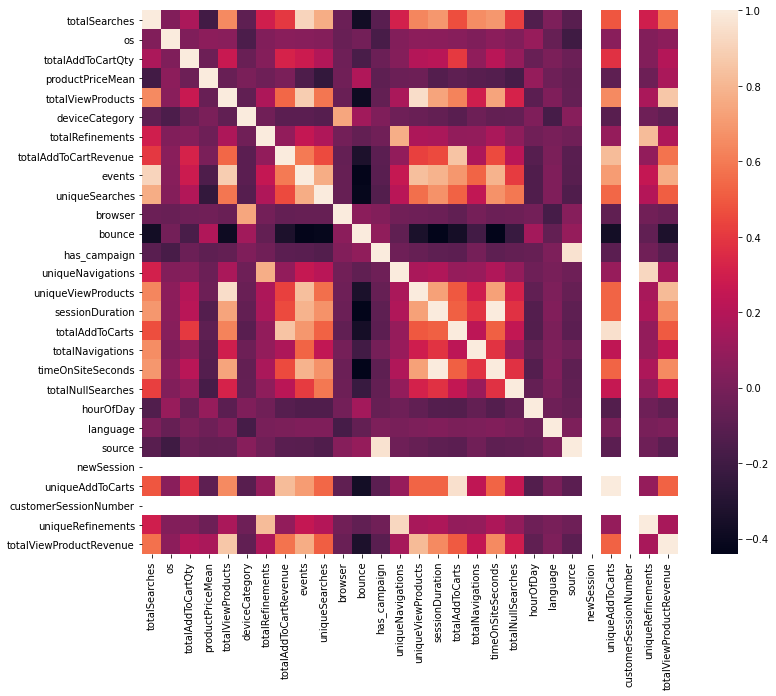

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
cor = x.corr()
sns.heatmap(cor)
plt.show()

In [12]:
import numpy as np

keep_columns = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if np.abs(cor.iloc[i,j]) >= 0.8:
            if keep_columns[j]:
                keep_columns[j] = False
                print(f'Feature "{x.columns[j]}" is highly related to "{x.columns[i]}". Remove "{x.columns[j]}"')
print(len(np.full((cor.shape[0],), True, dtype=bool)))
selected_columns = x.columns[keep_columns]
df_out = x[selected_columns]
print('-----')
print('The following columns are present in the new df:')
print(selected_columns)
print(f'The old df had {x.shape[1]} features. The new df has {df_out.shape[1]} features.')


Feature "events" is highly related to "totalSearches". Remove "events"
Feature "uniqueViewProducts" is highly related to "totalViewProducts". Remove "uniqueViewProducts"
Feature "totalViewProductRevenue" is highly related to "totalViewProducts". Remove "totalViewProductRevenue"
Feature "uniqueRefinements" is highly related to "totalRefinements". Remove "uniqueRefinements"
Feature "totalAddToCarts" is highly related to "totalAddToCartRevenue". Remove "totalAddToCarts"
Feature "uniqueAddToCarts" is highly related to "totalAddToCartRevenue". Remove "uniqueAddToCarts"
Feature "source" is highly related to "has_campaign". Remove "source"
Feature "timeOnSiteSeconds" is highly related to "sessionDuration". Remove "timeOnSiteSeconds"
28
-----
The following columns are present in the new df:
Index(['totalSearches', 'os', 'totalAddToCartQty', 'productPriceMean',
       'totalViewProducts', 'deviceCategory', 'totalRefinements',
       'totalAddToCartRevenue', 'uniqueSearches', 'browser', 'bounce'

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


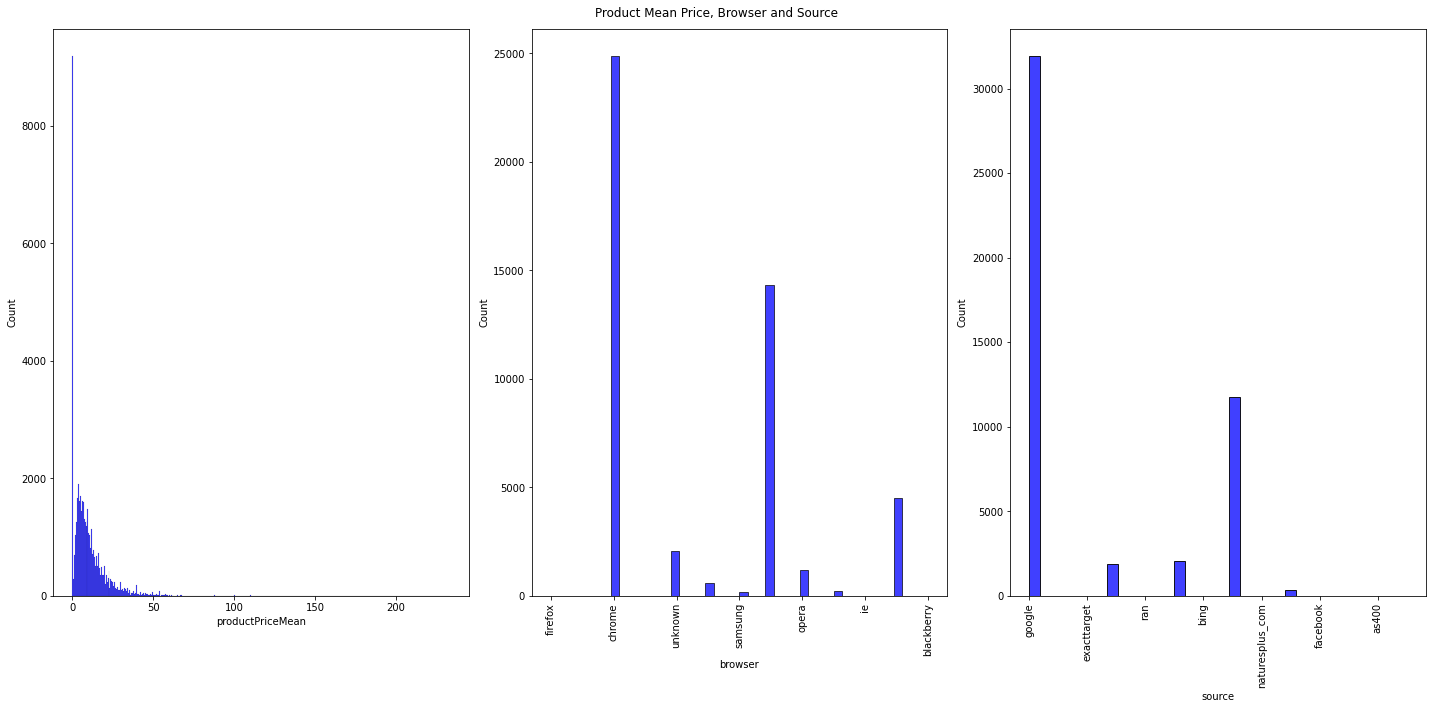

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

data_red = cleaned_df[['productPriceMean','browser','source']]

fig = plt.figure(figsize = (20, 10))
j = 0
for i in data_red.columns:
    plt.subplot(1, 3, j+1)
    j += 1
    plot_obj = sns.histplot(data_red[i], color='b')
    
    if i=='browser':
        plot_obj.set_xticklabels(pd.unique(transformed_df['browser']),rotation=90)
    elif i=='source':
        plot_obj.set_xticklabels([i or 'None' for i in pd.unique(transformed_df['source'])],rotation=90)
        
fig.suptitle('Product Mean Price, Browser and Source')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [14]:
filtered_x = x[selected_columns]

In [15]:
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier

feature_names = [f'feature {i}' for i in range(filtered_x.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(filtered_x,y)

start_time = time.time()
result = permutation_importance(
    forest, filtered_x, y, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Elapsed time to compute the importances: 60.135 seconds


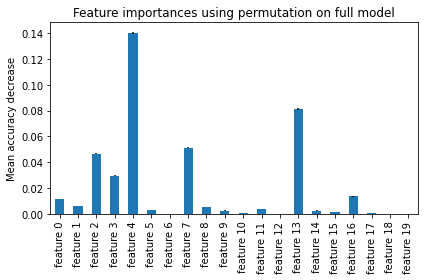

In [16]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [17]:
importances = pd.DataFrame(forest_importances, columns=['score'])
importances = importances.sort_values(by='score', ascending=False)
importances.loc[:,'feature'] = [filtered_x.columns[int(i.replace('feature ',''))] for i in importances.index]
importances[importances['score']>0.01]
x = filtered_x[list(importances[importances['score']>0.01]['feature'].values)]
importances[importances['score']>0.01]

,score,feature
feature 4,0.140319,totalViewProducts
feature 13,0.081405,sessionDuration
feature 7,0.051302,totalAddToCartRevenue
feature 2,0.046587,totalAddToCartQty
feature 3,0.029566,productPriceMean
feature 16,0.013762,hourOfDay
feature 0,0.011353,totalSearches


## Model Training

### Best model for recall

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x.values, y, test_size=0.33, random_state=42)

In [19]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.metrics import classification_report


exported_pipeline = make_pipeline(
    StandardScaler(),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=7, min_samples_split=2)),
    BernoulliNB(alpha=10.0, fit_prior=False)
)
set_param_recursive(exported_pipeline.steps, 'random_state', 42)
exported_pipeline.fit(x_train, y_train.values.ravel())
results = exported_pipeline.predict(x_test)

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [20]:
pd.DataFrame(classification_report(y_test, results, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.997326,0.423518,0.883744,0.710422,0.947991
recall,0.875155,0.975055,0.883744,0.925105,0.883744
f1-score,0.932255,0.590535,0.883744,0.761395,0.902875
support,14490.000000,1363.000000,0.883744,15853.000000,15853.000000


In [55]:
uuu = np.concatenate([x_test[:,4][:,np.newaxis],results[:,np.newaxis]],axis=1)

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(random_state=0))])
clf = pipe.fit(x_test[:,4][:,np.newaxis], y_test)
classifier = clf.named_steps['clf']
classifier.coef_

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[-0.17201968]])

array([[<AxesSubplot:title={'center':'not converted'}>]], dtype=object)

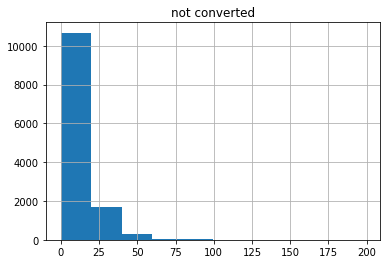

In [89]:
pd.DataFrame(uuu[np.where(uuu[:,1]==0),0].reshape(-1), columns=['not converted']).hist()

In [125]:
df['hits'][0][0]['product'][0]['sku']
unique_ids = []
for x in df['hits']:
    for y in x:
        products = y['product']
        for p in products:
            unique_ids.append(p.get('sku'))
all_ids = set(unique_ids)

In [349]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42, scoring="recall")
tpot.fit(x_train, y_train.values.ravel())

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9398465000865601

Generation 2 - Current best internal CV score: 0.949155878713268

Generation 3 - Current best internal CV score: 0.9577490526477772

Generation 4 - Current best internal CV score: 0.9577490526477772

Generation 5 - Current best internal CV score: 0.9749341181449209

Best pipeline: BernoulliNB(DecisionTreeClassifier(StandardScaler(input_matrix), criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=2), alpha=10.0, fit_prior=False)


TPOTClassifier(generations=5, population_size=50, random_state=42,
               scoring='recall', verbosity=2)

In [350]:
predictions = tpot.predict(x_test)
pd.DataFrame(classification_report(y_test, predictions, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.997636,0.421835,0.882861,0.709736,0.948131
recall,0.873913,0.977990,0.882861,0.925951,0.882861
f1-score,0.931685,0.589432,0.882861,0.760559,0.902259
support,14490.000000,1363.000000,0.882861,15853.000000,15853.000000


## Best F1

In [14]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42, scoring="f1")
tpot.fit(x_train, y_train.values.ravel())

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6183608325432679

Generation 2 - Current best internal CV score: 0.6183608325432679

Generation 3 - Current best internal CV score: 0.6183608325432679

Generation 4 - Current best internal CV score: 0.6185427701889705

Generation 5 - Current best internal CV score: 0.6303642968632033

Best pipeline: GaussianNB(XGBClassifier(OneHotEncoder(XGBClassifier(input_matrix, learning_rate=0.01, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0), minimum_fraction=0.25, sparse=False, threshold=10), learning_rate=1.0, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0))


TPOTClassifier(generations=5, population_size=50, random_state=42, scoring='f1',
               verbosity=2)

## Overall best model

In [99]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


exported_pipeline = XGBClassifier(
    learning_rate=0.1, max_depth=4, min_child_weight=8, n_estimators=100, n_jobs=1, 
    subsample=0.9500000000000001, verbosity=0, random_state=42)
exported_pipeline.fit(x_train, list(y_train.values.ravel()))
results = exported_pipeline.predict(x_test)
pd.DataFrame(classification_report(y_test, results, output_dict=True))

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,0,1,accuracy,macro avg,weighted avg
precision,0.973682,0.733184,0.953384,0.853433,0.953005
recall,0.975362,0.719736,0.953384,0.847549,0.953384
f1-score,0.974522,0.726398,0.953384,0.850460,0.953189
support,14490.000000,1363.000000,0.953384,15853.000000,15853.000000


## Sequential Modeling

#### Getting sequences for every session

In [3]:
oo = df[['hits']].apply(
    lambda x: [list(set([j.get('eventType').get('category') for j in hit])) for hit in x]
)['hits']
event_type_map = {y:index+1 for index, y in enumerate([i for i in pd.unique(oo.explode()) if type(i)==str])}
event_type_map

{'viewProduct': 1, 'addToCart': 2, 'search': 3, 'order': 4}

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

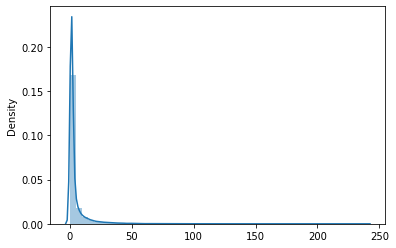

In [4]:
sequence_df = df.copy(deep=True)
sequence_df.loc[:,'sequence'] = sequence_df[['hits']].apply(
    lambda x: [
        [event_type_map[j[0]] 
         for j in sorted([(j.get('eventType').get('category'),j.get('hitSequence')) for j in hit])] 
        for hit in x]
)['hits']
length = sequence_df['sequence'].map(len).to_list()
sns.distplot(length)

In [5]:
total_df = []
for i in range(len(df['totals'])):
    new_dict = {k:float(v) if 'total' in k or 'unique' in k else v for k,v in df.iloc[i]['totals'].items()}
    total_df.append(new_dict)
sequence_df = pd.concat([sequence_df, pd.DataFrame(total_df)],axis=1)
sequence_df = sequence_df.fillna(0)
sequence_df.loc[:,'has_purchase'] = sequence_df['totalOrders'].transform(lambda x: 1 if int(x)>0 else 0)

In [6]:
sequence_df_50 = sequence_df[['customerSessionId','sequence','has_purchase']][sequence_df['sequence'].map(len) <= 50]

In [7]:
sequence_df_40 = sequence_df[['customerSessionId','sequence','has_purchase']][sequence_df['sequence'].map(len) <= 40]

In [8]:
# event_sequence = sequence_df_50['sequence'].to_list()
event_sequence = sequence_df_40['sequence'].to_list()

In [9]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
event = pad_sequences(event_sequence)

In [10]:
# One Hot Encoding the Purchase label
# y = np.array(pd.get_dummies(sequence_df_50['has_purchase'],prefix='Purchase'))
y = np.array(pd.get_dummies(sequence_df_40['has_purchase'],prefix='Purchase'))
z=np.sum(y[:,1])/len(y)
print('Percentage of Purchase sessions=',z*100)

Percentage of Purchase sessions= 7.988078126321129


In [11]:
x_train, x_test, y_train, y_test = train_test_split(np.array(event), y, test_size=0.3)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

### Model Training

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from tensorflow.keras.layers import GRU, Embedding, SimpleRNN, Activation
import tensorflow as tf
from groupby_user_conversion import GroupBy, FeatureSelection, Evaluation

def LSTM_model(neurons=40, op=10):
    #first define Sequential model
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, return_sequences=True), input_shape=(1,op)))
    model.add(Bidirectional(LSTM(2*neurons)))
    model.add(Dropout(0.7))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall()])
    return model

In [16]:
tf.keras.backend.clear_session()
lstm_model = LSTM_model(op=40)

# G_model.summary()
lstm_history = lstm_model.fit(x_train, y_train,epochs=100,batch_size=1000,validation_split=0.2)

Epoch 1/100
27/27 [==============================] - 11s 122ms/step - loss: 0.6840 - recall: 0.6660 - val_loss: 0.6532 - val_recall: 0.8717
Epoch 2/100
27/27 [==============================] - 1s 33ms/step - loss: 0.6413 - recall: 0.8832 - val_loss: 0.5949 - val_recall: 0.8968
Epoch 3/100
27/27 [==============================] - 1s 30ms/step - loss: 0.5790 - recall: 0.8998 - val_loss: 0.5160 - val_recall: 0.9047
Epoch 4/100
27/27 [==============================] - 1s 28ms/step - loss: 0.4982 - recall: 0.9064 - val_loss: 0.4328 - val_recall: 0.9087
Epoch 5/100
27/27 [==============================] - 1s 28ms/step - loss: 0.4227 - recall: 0.9094 - val_loss: 0.3627 - val_recall: 0.9108
Epoch 6/100
27/27 [==============================] - 1s 27ms/step - loss: 0.3541 - recall: 0.9113 - val_loss: 0.3124 - val_recall: 0.9124
Epoch 7/100
27/27 [==============================] - 1s 29ms/step - loss: 0.3067 - recall: 0.9128 - val_loss: 0.2819 - val_recall: 0.9134
Epoch 8/100
27/27 [=============

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


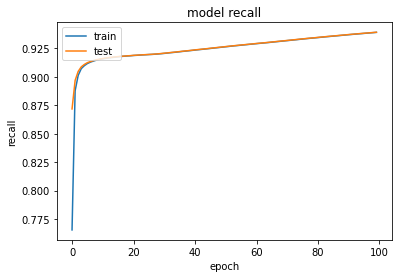

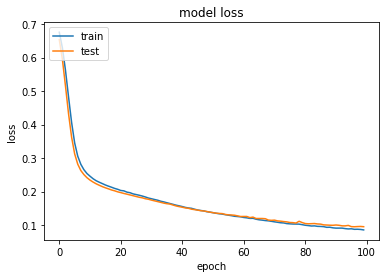

In [17]:
Evaluation.plot_history(lstm_history)

In [18]:
Evaluation.evaluate_nn_model(x_test, y_test, lstm_model)

/Users/paulokuong/Documents/personal/fourth_brain_course/env/lib/python3.7/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.949341
Precision: 0.770270
Recall: 0.509383
F1 score: 0.613233
